In [1]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

# Generating the samples for Auto Regrssive Model

In [2]:
def generate_samples():
    noise = np.random.uniform(0,0.1,2003)
    x = np.array([noise[0],noise[1],noise[2]])
    i = 4
    while i <=2003:
        xt = np.sum(x[-3:]*a_coeffs)+noise[i-1]
        x = np.append(x,xt)
        i = i+1
  
    x_ = []
    y_ = []

    for i in range(len(x)-seq_len):
        seq = x[i:(i+seq_len)]
        output = x[i+seq_len]
        x_.append(seq)
        y_.append(output)

    x_ = torch.from_numpy(np.array(x_).transpose()).float()
    y_ = torch.from_numpy(np.array(y_)).float()

    x_ = x_.view([3,2000,-1])

    return x, x_, y_

a_coeffs = np.array([0.6, -0.5, -0.2])
seq_len = 3

series_train, x_train, y_train = generate_samples()
series_test, x_test, y_test = generate_samples()

# Plotting the both Test and Train AR-Series

The sample values in the series are plotted over 2000 time-steps

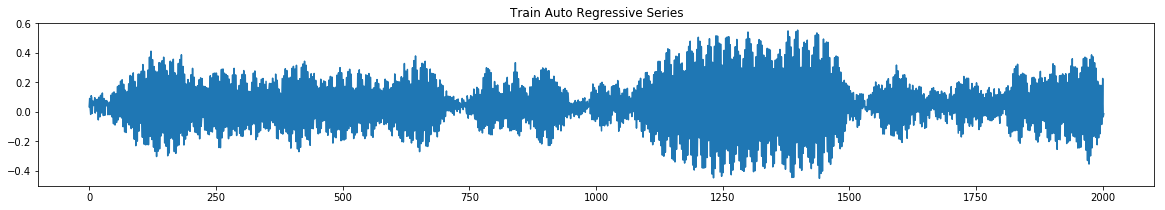

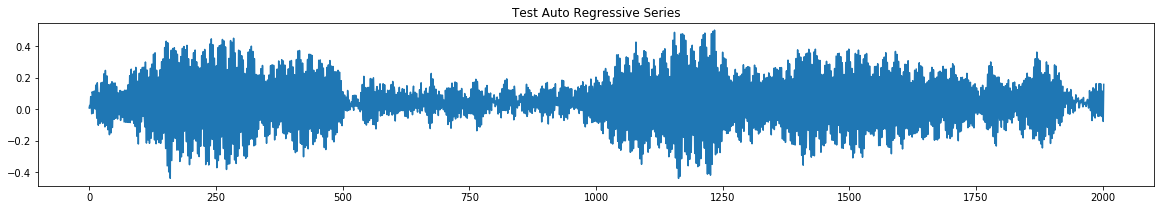

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

plt.figure()
plt.title("Train Auto Regressive Series")
plt.plot(series_train)
plt.show()

plt.figure()
plt.title("Test Auto Regressive Series")
plt.plot(series_test)
plt.show()

# Defining the RNN model structure

The model structure has 1 or 2 or 3 RNN layer(s) and then has a linear layer

The model takes a sequence of length 3 $(X_{t-1}$ to $X_{t-3})$ and predicts the next (4th) $(X_t)$ element in the series. The window of length 3 is moved over the whole series to predict the all elements in the series.

In [4]:
class AR_RNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, seq_len, batch_size, num_layers):
        super(AR_RNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size = input_dim,
                            hidden_size = hidden_dim,
                            num_layers = num_layers)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=1)
        
    def reset_hidden_states(self):
        self.hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
        
    def forward(self, input):
       
        rnn_out, self.hidden = self.rnn(input)
               
        y_pred = self.linear(rnn_out[-1])
            
        return y_pred.view(-1)

# Training the RNN model

Number of epochs = 500

Learning rate = 0.0001

Loss = Mean Square Error

Hidden State size = 20 (for all variations)

In [5]:
def train_model(model, train_data, train_labels):
    loss_fn  = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr = 1e-3)
    
    num_epochs = 500
    
    train_hist = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        
        #model.reset_hidden_states()#comment out for stateless RNN
        
        y_pred = model(x_train)
        
        loss = loss_fn(y_pred, y_train)
        
        #if epoch %100 == 0:
            #print("Epoch and trainloss:", epoch,loss.item())
            
        train_hist[epoch] = loss.item()
        
        optimiser.zero_grad()
        
        loss.backward()
        
        optimiser.step()
        
    return model.eval(), train_hist

# Varying RNN Number of layers : 1, 2, 3

In [6]:
model1 = AR_RNN(1, 20, seq_len=seq_len,batch_size=2000, num_layers=1)
model1, train_hist1 = train_model(model1, x_train, y_train)

model2 = AR_RNN(1, 20, seq_len=seq_len,batch_size=2000, num_layers=2)
model2, train_hist2 = train_model(model2, x_train, y_train)

model3 = AR_RNN(1, 20, seq_len=seq_len,batch_size=2000, num_layers=3)
model3, train_hist3 = train_model(model3, x_train, y_train)

# Plotting Epoch- MSE curve for all variation

Initially, the errors curve followed different trends for all variations but finally, all saturated.

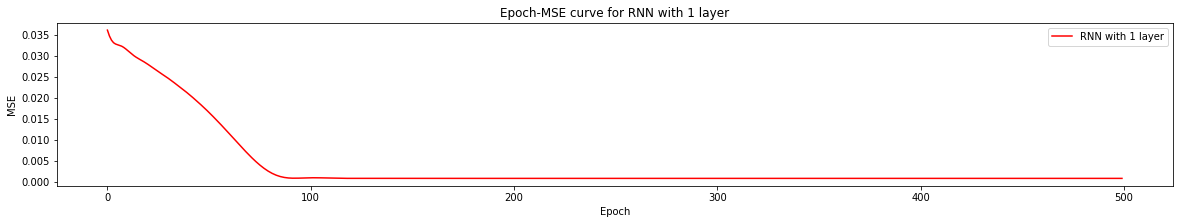

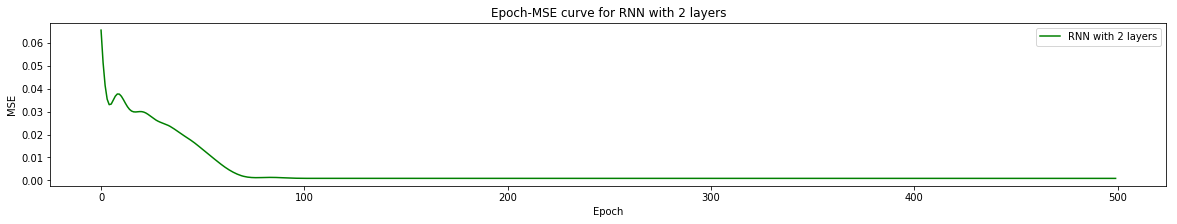

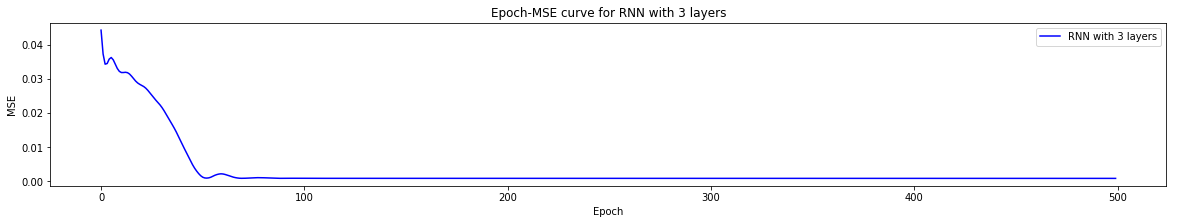

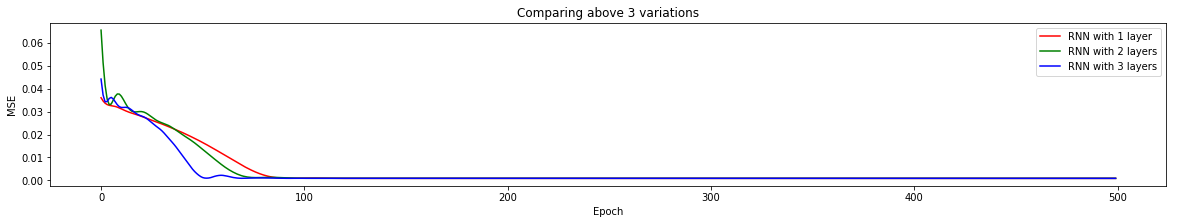

In [7]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 1 layer')
plt.plot(train_hist1,color="red",label='RNN with 1 layer')
plt.legend()
plt.figure(2)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 2 layers')
plt.plot(train_hist2,color="green",label='RNN with 2 layers')
plt.legend()
plt.figure(3)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Epoch-MSE curve for RNN with 3 layers')
plt.plot(train_hist3,color="blue",label='RNN with 3 layers')
plt.legend()
plt.figure(4)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Comparing above 3 variations')
plt.plot(train_hist1,color="red",label='RNN with 1 layer')
plt.plot(train_hist2,color="green",label='RNN with 2 layers')
plt.plot(train_hist3,color="blue",label='RNN with 3 layers')
plt.legend()
plt.show()

# Predictions for Test Data

In [8]:
with torch.no_grad():
    pred1 = torch.flatten(model1(x_test))
    pred2 = torch.flatten(model2(x_test))
    pred3 = torch.flatten(model3(x_test))

# Plotting Actual Test series and the Predicted Series for all variations

From the below plots, we can observe that for all the variations, the predicted series almost matches with the actual test series

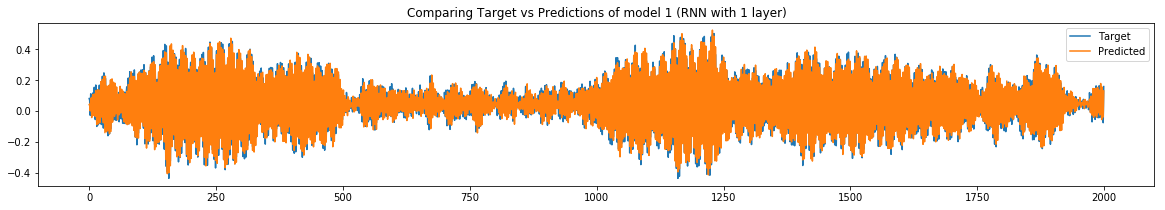

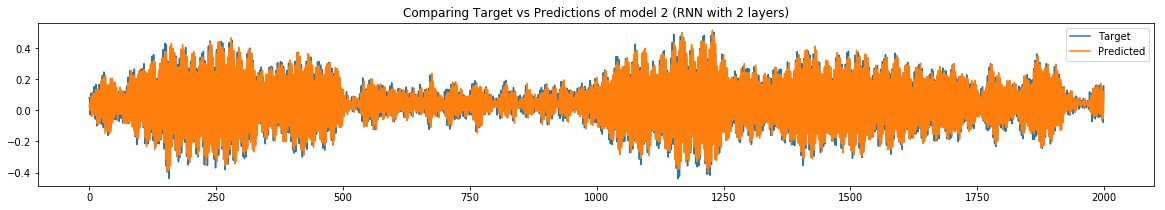

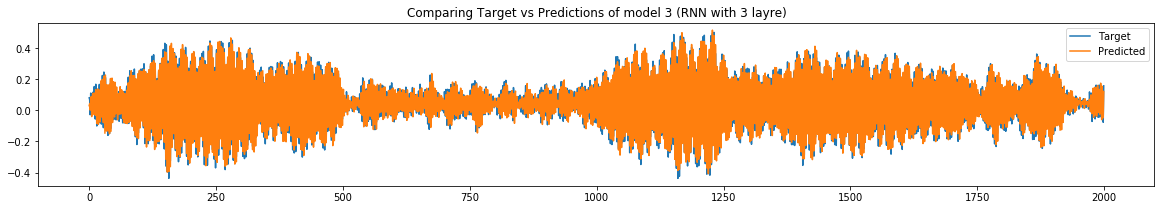

In [9]:
plt.figure()
plt.title("Comparing Target vs Predictions of model 1 (RNN with 1 layer)")
plt.plot(y_test,label="Target")
plt.plot(pred1,label="Predicted")
plt.legend()
plt.show()

plt.figure()
plt.title("Comparing Target vs Predictions of model 2 (RNN with 2 layers)")
plt.plot(y_test,label="Target")
plt.plot(pred2,label="Predicted")
plt.legend()
plt.show()

plt.figure()
plt.title("Comparing Target vs Predictions of model 3 (RNN with 3 layre)")
plt.plot(y_test,label="Target")
plt.plot(pred3,label="Predicted")
plt.legend()
plt.show()

# Defining the Losses: MSE, MAE, R2

In [10]:
y_test = torch.flatten(y_test)

mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss()   

x = mae(pred1,y_test)

def r2score(target, pred):
    mean = torch.mean(target)
    sstot = torch.sum((target-mean)**2)
    ssres = torch.sum((target-pred)**2)
    r2score = 1-(ssres/sstot)
    return r2score

# Reporting the MSE, MAE and R2 Score for all variations

All the variations (#layers = 1,2,3) shown approximately the same errors.

In [11]:
print("Number of layers = 1 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred1,y_test)),np.array(mae(pred1,y_test)),np.array(r2score(pred1,y_test))))
print("Number of layers = 2 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred2,y_test)),np.array(mae(pred2,y_test)),np.array(r2score(pred2,y_test))))
print("Number of layers = 3 : MSE = %s, MAE = %s, R2score = %s"
      %(np.array(mse(pred3,y_test)),np.array(mae(pred3,y_test)),np.array(r2score(pred3,y_test))))

Number of layers = 1 : MSE = 0.00084163813, MAE = 0.025162172, R2score = 0.97119206
Number of layers = 2 : MSE = 0.00087110006, MAE = 0.025432186, R2score = 0.9702599
Number of layers = 3 : MSE = 0.0008618308, MAE = 0.02534988, R2score = 0.9705559
